# Chapter 7: Deep Generative Models

This notebook covers **Chapter 7** of the Deep Learning in Hebrew book, focusing on Deep Generative Models. We'll learn how to build models that can generate new data samples based on learned patterns.

## Overview

The models presented in previous chapters are **discriminative models**, meaning they are trained to perform operations based on the data - they learn to distinguish between different examples and classify them. However, there are also **generative models** that, in addition to classification, can create new pieces of data based on the examples learned.

Formally, given a set of examples $X \in \mathbb{R}^{n \times d}$ and a set of labels $Y \in \mathbb{R}^n$, a discriminative model is trained to estimate the probability $\Pr(y|x)$. A generative model, on the other hand, models the probability $\Pr(x,y)$ (or $\Pr(x)$ in the case where labels are not given), where $x,y$ are a given pair of example and label, and can generate new examples.

There are several types of generative models: one type of models is trained to find an explicit form of the distribution of the given data, and with this distribution to generate new examples. Another type (which we will not detail in this chapter) does not deal with estimating the distribution of the original data, but generates new examples in other ways.

In this chapter, we will focus on the popular models in the field - **VAE** and **GANs**, which are the two main types of generative models.

---

## Table of Contents

### 7.1 Variational AutoEncoder (VAE)
- 7.1.1 [Dimensionality Reduction](#711-dimensionality-reduction)
- 7.1.2 [Autoencoders (AE)](#712-autoencoders-ae)
- 7.1.3 [Variational AutoEncoders (VAE)](#713-variational-autoencoders-vae)

### 7.2 Generative Adversarial Networks (GANs)
- 7.2.1 [Generator and Discriminator](#721-generator-and-discriminator)
- 7.2.2 [Deep Convolutional GAN (DCGAN)](#722-deep-convolutional-gan-dcgan)
- 7.2.3 [Conditional GAN (cGAN)](#723-conditional-gan-cgan)
- 7.2.4 [Pix2Pix](#724-pix2pix)
- 7.2.5 [CycleGAN](#725-cyclegan)
- 7.2.6 [Progressively Growing GAN (ProGAN)](#726-progressively-growing-gan-progan)
- 7.2.7 [StyleGAN](#727-stylegan)
- 7.2.8 [Wasserstein GAN](#728-wasserstein-gan)

## Setup and Imports

Let's start by importing the necessary libraries for this chapter.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from torchvision.utils import make_grid, save_image
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Set matplotlib style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# 7.1 Variational AutoEncoder (VAE)

The first model is **VAE**, and to understand how it can be used to generate new data, we will first explain what **Autoencoders** are, how they work, and what their disadvantages are.

An **Autoencoder** is a network trained to perform dimensionality reduction on data, with minimal loss of information. To understand its structure and mode of operation, we will first discuss dimensionality reduction in general.

## 7.1.1 Dimensionality Reduction

In many cases, the data we want to analyze has a high dimension, meaning each sample has a large number of features. Usually, not all features are equally significant. For example - the stock price of a certain company is affected by many factors, but not all of them are equally important for predicting the company's future performance.

Another example - in the task of predicting a person's age from a facial image, not all pixels in the facial image will have the same importance for prediction. Since it is difficult to analyze high-dimensional data and build models on such data, in many cases we try to reduce the dimension of the data with minimal information loss as much as possible.

In the dimensionality reduction process, we try to obtain a new representation of the data with a lower dimension, where this representation consists of the most significant features of the data. There are various methods for dimensionality reduction - the goal is to find a representation in a lower dimension, in which only the significant features of the data are expressed.

### Latent Representation

The representation of the data in a lower dimension is called the **latent representation** or **latent code**, and as mentioned, it is possible to build models for various tasks based on the latent representation of the data rather than working with the original data.

To obtain a quality latent representation, we can use a mechanism called **decoder**, which examines the reconstruction ability of the data from its latent representation. In this way, if we can reconstruct the data from the latent representation with good accuracy, it means that the latent representation contains the important information of the data.

### Training Process

The training process is two-stage: a piece of information represented by a feature vector $x \in \mathbb{R}^n$ passes through an **encoder**, whose purpose is to compress the data into a latent representation $e(x) \in \mathbb{R}^m$ where $m < n$. Then the result is entered into a **decoder** to reconstruct the original data, and finally a vector $d(e(x)) \in \mathbb{R}^n$ is obtained.

If the equality $x = d(e(x))$ holds, it means that the dimensionality reduction was successful and we can reconstruct it fully in decoding. If $x \neq d(e(x))$, then there is some information loss in the dimensionality reduction process.

Intuitively, if we succeed in reconstructing the original data from the low-dimensional representation with good enough accuracy, the latent representation probably succeeded in extracting the significant features of the original data.

### Optimization Problem

The main goal of dimensionality reduction is to obtain as quality a latent representation as possible. The way to do this is to train the encoder-decoder pair so that they preserve maximum information during encoding, and bring to minimum the reconstruction error between the original data and the reconstructed data.

If we denote the encoder by $E$ and the decoder by $D$, we can formulate the dimensionality reduction problem as follows:

$$(e^*, d^*) = \arg\min_{(e,d) \in \mathcal{E} \times \mathcal{D}} \epsilon(x, d(e(x)))$$

where $\epsilon(x, d(e(x)))$ is the reconstruction error between the original data and the reconstructed data.

### Principal Component Analysis (PCA)

One useful method for dimensionality reduction is **Principal Component Analysis (PCA)**. In this method, we project (linearly) data from dimension $n$ to dimension $m < n$, so that the features of the latent representation of the original examples are orthogonal. This process is also called **feature decorrelation**, and its goal is to minimize the Euclidean distance between the original data and the reconstructed data, also linearly, from the new representation in the $m$-dimensional space.

To generalize PCA to a non-linear encoder-decoder pair, we can impose two conditions: a. The encoder performs a linear transformation on the data (to a lower dimension) so that the new features of the data are orthogonal. b. The linear decoder minimizes the reconstruction error between the original data and that reconstructed from the new representation.

It can be proven that the encoder is equivalent to the matrix of eigenvectors of the covariance matrix of the design matrix, and the decoder is the transpose of the encoder.

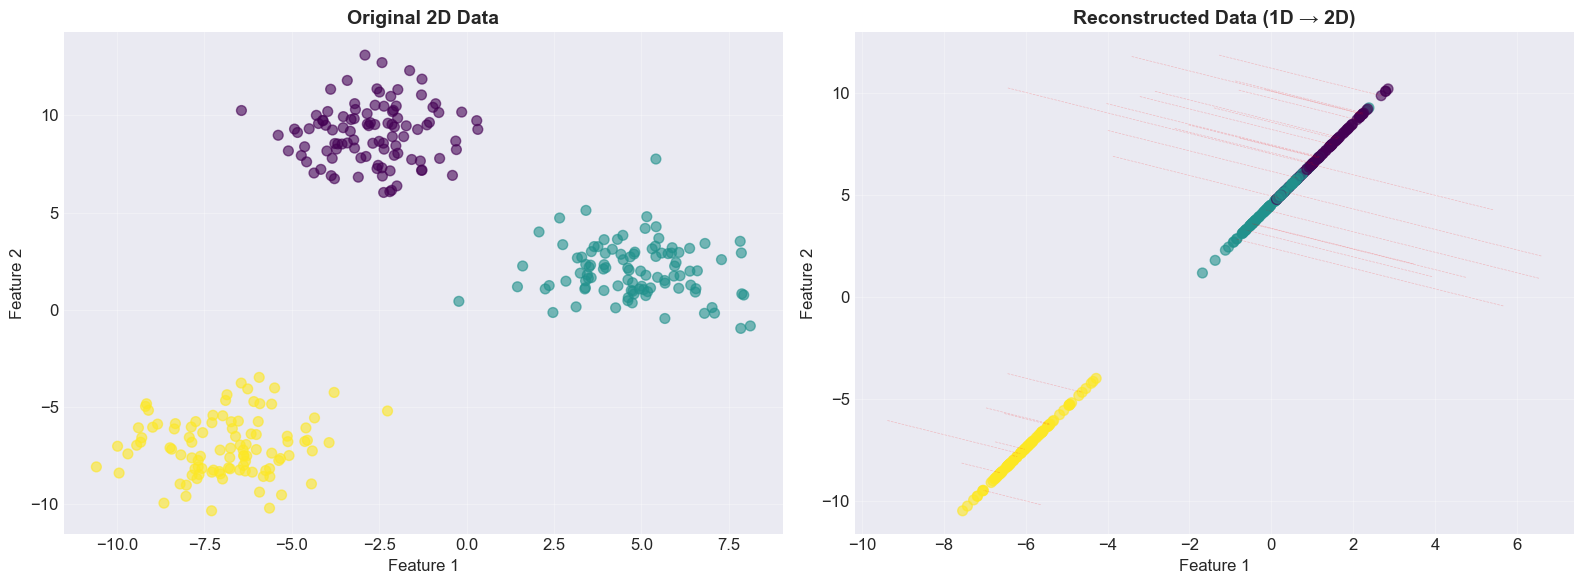

PCA Dimensionality Reduction:
Original dimension: 2
Latent dimension: 1
Reconstruction error: 9.3774
Explained variance ratio: 0.7359


In [2]:
# PCA Example for Dimensionality Reduction
from sklearn.datasets import make_blobs

# Generate 2D data
X, y = make_blobs(n_samples=300, centers=3, n_features=2, random_state=42, cluster_std=1.5)

# Apply PCA
pca = PCA(n_components=1)
X_pca = pca.fit_transform(X)
X_reconstructed = pca.inverse_transform(X_pca)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Original data
axes[0].scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', alpha=0.6, s=50)
axes[0].set_title('Original 2D Data', fontsize=14, weight='bold')
axes[0].set_xlabel('Feature 1', fontsize=12)
axes[0].set_ylabel('Feature 2', fontsize=12)
axes[0].grid(True, alpha=0.3)

# Reconstructed data
axes[1].scatter(X_reconstructed[:, 0], X_reconstructed[:, 1], c=y, cmap='viridis', alpha=0.6, s=50)
axes[1].set_title('Reconstructed Data (1D → 2D)', fontsize=14, weight='bold')
axes[1].set_xlabel('Feature 1', fontsize=12)
axes[1].set_ylabel('Feature 2', fontsize=12)
axes[1].grid(True, alpha=0.3)

# Draw projection lines
for i in range(0, len(X), 10):  # Show every 10th point
    axes[1].plot([X[i, 0], X_reconstructed[i, 0]], 
                 [X[i, 1], X_reconstructed[i, 1]], 
                 'r--', alpha=0.2, linewidth=0.5)

plt.tight_layout()
plt.show()

print("PCA Dimensionality Reduction:")
print("=" * 50)
print(f"Original dimension: {X.shape[1]}")
print(f"Latent dimension: {X_pca.shape[1]}")
print(f"Reconstruction error: {np.mean((X - X_reconstructed)**2):.4f}")
print(f"Explained variance ratio: {pca.explained_variance_ratio_[0]:.4f}")

## 7.1.2 Autoencoders (AE)

We can now generalize the encoder-decoder pair to deep neural networks for both the new representation and reconstruction. This structure is called an **Autoencoder**:

### Autoencoder Architecture

In this way, the architecture creates an information bottleneck for the data, which ensures that only the important features of the data, through which it is possible to reconstruct it with good accuracy, will be used for representation in the latent space.

In the simple case where each network has only one hidden layer and does not use non-linear activation functions, it can be seen that the autoencoder will look for a linear transformation of the data, through which it is possible to reconstruct linearly as well. Similar to PCA, such a network will also try to reduce the dimension through linear transformations of the original features, but the representation in low dimension produced by it will not necessarily be identical to that of PCA, since unlike PCA, the new features (after dimensionality reduction) may not be orthogonal (correlation different from 0).

### Deep Autoencoders

Now let's assume that the networks of the encoder and decoder are deep networks and use non-linear activation functions. In this case, the architecture can be much more complex than the simple case, and a deep encoder network can reduce dimensions in a non-linear way, and the ability to reconstruct through the decoder without any information loss.

Theoretically, if the encoder and decoder have enough degrees of freedom (for example, enough layers in a neural network), it is possible to reduce the dimension of any data to one dimension without any information loss. However, such a drastic dimensionality reduction may cause the reconstructed data to lose the structure that is important.

### Latent Space Choice

There is great importance in choosing the number of dimensions of the latent space, so that on the one hand, filtering of less significant features will indeed be performed, and on the other hand, the information will still be meaningful for various downstream tasks.

### Limitations of Autoencoders

The main limitation of autoencoders is that they do not provide a way to generate new data. If we sample a random vector from the latent space, it is likely that it will not correspond to any data similar to the original data. If we input it to the decoder, it is likely that the output will not be similar to the original data at all.

For example, if an AE is trained on a set of images of dogs, and we randomly sample a vector from its latent space, the chance of getting some dog image after reconstruction by the decoder is zero.

Autoencoder Architecture:
Input dimension: 784
Latent dimension: 32
Compression ratio: 24.5:1

Input shape: torch.Size([10, 784])
Latent code shape: torch.Size([10, 32])
Reconstructed shape: torch.Size([10, 784])
Reconstruction error: 1.2471


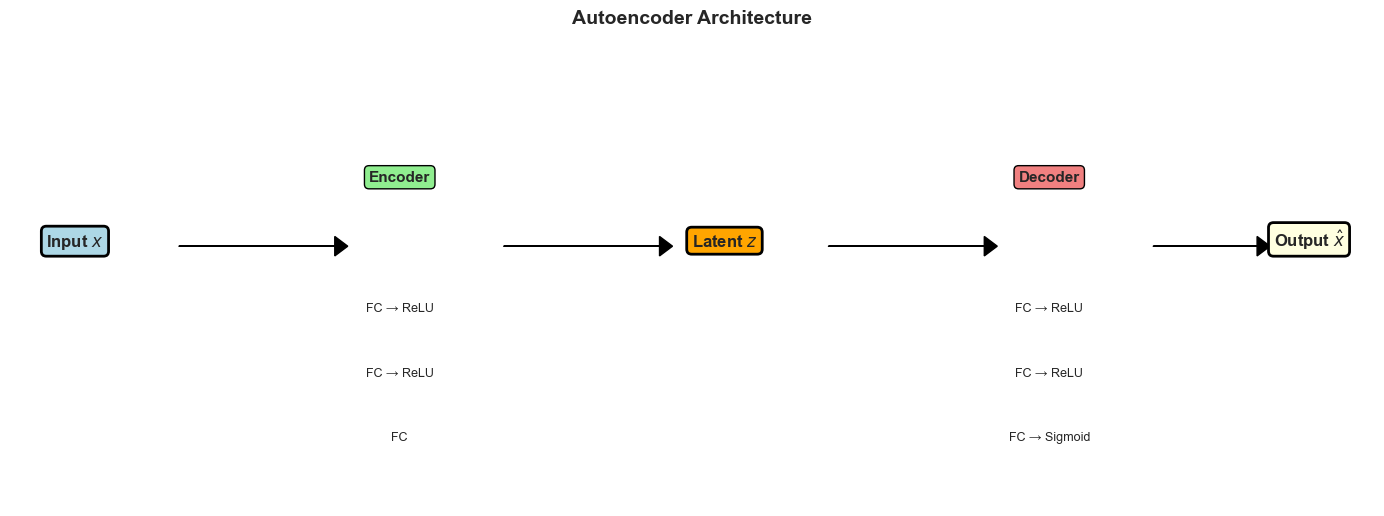

In [3]:
# Simple Autoencoder Implementation
class Autoencoder(nn.Module):
    """
    Simple Autoencoder for dimensionality reduction.
    """
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            nn.Sigmoid()  # For image data
        )
    
    def forward(self, x):
        # Encode
        z = self.encoder(x)
        # Decode
        x_reconstructed = self.decoder(z)
        return x_reconstructed, z

# Test Autoencoder
input_dim = 784  # 28x28 image
latent_dim = 32

autoencoder = Autoencoder(input_dim, latent_dim)

# Create dummy data
x = torch.randn(10, input_dim)

# Forward pass
x_recon, z = autoencoder(x)

print("Autoencoder Architecture:")
print("=" * 50)
print(f"Input dimension: {input_dim}")
print(f"Latent dimension: {latent_dim}")
print(f"Compression ratio: {input_dim / latent_dim:.1f}:1")
print(f"\nInput shape: {x.shape}")
print(f"Latent code shape: {z.shape}")
print(f"Reconstructed shape: {x_recon.shape}")
print(f"Reconstruction error: {F.mse_loss(x, x_recon).item():.4f}")

# Visualize architecture
fig, ax = plt.subplots(figsize=(14, 6))
ax.set_xlim(-0.5, 10)
ax.set_ylim(-0.5, 3)
ax.set_aspect('equal')
ax.axis('off')
ax.set_title('Autoencoder Architecture', fontsize=14, weight='bold', pad=20)

# Input
ax.text(0, 1.5, 'Input $x$', fontsize=12, weight='bold', ha='center',
        bbox=dict(boxstyle='round', facecolor='lightblue', edgecolor='black', linewidth=2))

# Encoder
ax.text(2.5, 2, 'Encoder', fontsize=11, weight='bold', ha='center',
        bbox=dict(boxstyle='round', facecolor='lightgreen', edgecolor='black'))
ax.text(2.5, 1, 'FC → ReLU', fontsize=9, ha='center')
ax.text(2.5, 0.5, 'FC → ReLU', fontsize=9, ha='center')
ax.text(2.5, 0, 'FC', fontsize=9, ha='center')

# Latent (bottleneck)
ax.text(5, 1.5, 'Latent $z$', fontsize=12, weight='bold', ha='center',
        bbox=dict(boxstyle='round', facecolor='orange', edgecolor='black', linewidth=2))

# Decoder
ax.text(7.5, 2, 'Decoder', fontsize=11, weight='bold', ha='center',
        bbox=dict(boxstyle='round', facecolor='lightcoral', edgecolor='black'))
ax.text(7.5, 1, 'FC → ReLU', fontsize=9, ha='center')
ax.text(7.5, 0.5, 'FC → ReLU', fontsize=9, ha='center')
ax.text(7.5, 0, 'FC → Sigmoid', fontsize=9, ha='center')

# Output
ax.text(9.5, 1.5, 'Output $\\hat{x}$', fontsize=12, weight='bold', ha='center',
        bbox=dict(boxstyle='round', facecolor='lightyellow', edgecolor='black', linewidth=2))

# Arrows
ax.arrow(0.8, 1.5, 1.2, 0, head_width=0.15, head_length=0.1, fc='black', ec='black')
ax.arrow(3.3, 1.5, 1.2, 0, head_width=0.15, head_length=0.1, fc='black', ec='black')
ax.arrow(5.8, 1.5, 1.2, 0, head_width=0.15, head_length=0.1, fc='black', ec='black')
ax.arrow(8.3, 1.5, 0.8, 0, head_width=0.15, head_length=0.1, fc='black', ec='black')

plt.tight_layout()
plt.show()

### ELBO (Evidence Lower BOund)

After presenting the general structure of the VAE, we can now describe the training, and for this we will separate at this stage between the two parts of the VAE. The encoder trains a network that receives examples from the training set, and tries to produce from them parameters of a distribution $z|x$ close as possible to the parameters of the prior distribution $z$, and this is the distribution we sample from.

We sample random vectors and pass them to the decoder. The decoder uses the function - takes a vector from the latent space $z|x$ and, with the help of an example, produces output similar to the original data. The training process will be such that it minimizes the error of both parts of the VAE - both $x|z$ at the output will be as close as possible to $x$, and the distance between the distribution $z|x$ at the output of the encoder and the prior distribution $z$.

Let us formally describe the optimization problem that the VAE tries to solve. We denote the vectors of the latent space by $z$, the parameters of the decoder by $\theta$, and the parameters of the encoder by $\lambda$. To find the optimal parameters of the two networks, we want to maximize $p(X; \theta)$, i.e., maximize the maximum likelihood of the training set under $\theta$.

Since the log function is monotonic, we can take the log probability:

$$L(\theta) = \log p(x; \theta)$$

If we maximize this expression, we get the optimal $\theta$. Since it is not possible to explicitly calculate $p(x; \theta)$, we need to use an approximation. Let's assume that the output of the encoder has a distribution $q(z|x; \lambda)$ (what is the probability of getting $z$ given $x$ at the input), and we try to represent this distribution using a neural network with a set of parameters $\lambda$.

Now we can divide and multiply $L(\theta)$ by $q(z; \lambda)$:

$$\log p(x; \theta) = \log \sum_z p(x, z; \theta) = \log \sum_z q(z; \lambda) \frac{p(x, z; \theta)}{q(z; \lambda)} \geq \sum_z q(z; \lambda) \log \frac{p(x, z; \theta)}{q(z; \lambda)}$$

where the last inequality comes from Jensen's inequality, and is called **Evidence Lower BOund (ELBO)** $(\theta, \lambda)$.

It can be proven that the difference between the ELBO and the log probability is the distance between the distributions $p(z|x), q(z)$, called **Kullback-Leibler divergence** and denoted by $\mathcal{D}_{KL}$:

$$\log p(x; \theta) = \text{ELBO}(\theta, \lambda) + \mathcal{D}_{KL}(q(z; \lambda) \| p(z|x; \theta))$$

Since the distance $\mathcal{D}_{KL}$ is always non-negative, if the distributions are equal, then $\mathcal{D}_{KL} = 0$ and $\log p(x; \theta) = \text{ELBO}(\theta, \lambda)$.

As we remember, we are trying to maximize $\log p(x; \theta)$, and now with the help of the approximation we can write:

$$L(\theta) = \log p(x; \theta) \geq \text{ELBO}(\theta, \lambda)$$

$$\rightarrow \theta^* = \arg\max_{\theta} L(\theta) = \arg\max_{\theta} \max_{\lambda} \text{ELBO}(\theta, \lambda)$$

Now we can use the Gradient Descent (GD) method to find the optimum of the expression, and from it derive the optimal parameters of the encoder and decoder.

### ELBO Decomposition

We can expand the ELBO $(\theta, \lambda)$ with respect to the two distributions:

- $p(x|z; \theta)$ - The probability that the decoder with parameters $\theta$ will output $x$ given $z$.
- $q(z|x; \lambda)$ - The probability that the encoder with parameter set $\lambda$ will output $z$ given $x$ at the input.

Formally:

$$\text{ELBO}(\theta, \lambda) = \sum_z q(z|x; \lambda) \log p(x, z; \theta) - \sum_z q(z|x; \lambda) \log q(z|x; \lambda)$$

The expression $\log p(x, z; \theta)$ can be expanded according to Bayes' rule $p(x, z) = p(x|z) \cdot p(z)$:

$$= \sum_z q(z|x; \lambda)(\log p(x|z; \theta) + \log p(z; \theta)) - \sum_z q(z|x; \lambda) \log q(z|x; \lambda)$$

$$= \sum_z q(z|x; \lambda) \log p(x|z; \theta) - \sum_z q(z|x; \lambda)(\log q(z|x; \lambda) - \log p(z; \theta))$$

$$= \sum_z q(z|x; \lambda) \log p(x|z; \theta) - \sum_z q(z|x; \lambda) \log \frac{q(z|x; \lambda)}{p(z; \theta)}$$

The second expression is by definition equal to $\mathcal{D}_{KL}(q(z|x; \lambda) \| p(z; \theta))$, so:

$$= \sum_z q(z|x; \lambda) \log p(x|z; \theta) - \mathcal{D}_{KL}(q(z|x; \lambda) \| p(z))$$

The first expression is $\log p(x|z; \theta)$. Under the assumption that $z$ is from a normal distribution:

$$= \mathbb{E}_{q(z|x; \lambda)} \log \mathcal{N}(x; \mu_\theta(z), \sigma_\theta(z)) - \mathcal{D}_{KL}(\mathcal{N}(\mu_\lambda(x), \sigma_\lambda(x)) \| \mathcal{N}(0, I))$$

For the distribution $z|x \sim \mathcal{N}(\mu_\lambda(x), \sigma_\lambda(x))$, we can approximate:

$$\mathbb{E}_{q(z|x; \lambda)} \log \mathcal{N}(x; \mu_\theta(z), \sigma_\theta(z)) \approx \log \mathcal{N}(x; \mu_\theta(z), \sigma_\theta(z))$$

And for the KL divergence:

$$\mathcal{D}_{KL}(\mathcal{N}(\mu, \sigma^2) \| \mathcal{N}(0, I)) = \frac{1}{2}(\mu^2 + \sigma^2 - \log \sigma^2)$$

### Reparameterization Trick

The sampling of $z$ from the distribution in the latent space creates difficulty in calculating the gradient of the ELBO. In general, we perform **Reparameterization Trick** - we sample $\epsilon$ from a standard normal distribution, and then to get the value of the sample of $z$, we use the parameters of the encoder: $z = \epsilon \sigma_\lambda(x) + \mu_\lambda(x)$.

In this approach, the entire process becomes deterministic - we sample $\epsilon$ in advance and then only need to calculate schematically the derivatives.

In [ ]:
# VAE Implementation
class VAE(nn.Module):
    """
    Variational Autoencoder implementation.
    """
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 400),
            nn.ReLU(),
            nn.Linear(400, 200),
            nn.ReLU()
        )
        
        # Mean and log variance (for reparameterization trick)
        self.fc_mu = nn.Linear(200, latent_dim)
        self.fc_logvar = nn.Linear(200, latent_dim)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 200),
            nn.ReLU(),
            nn.Linear(200, 400),
            nn.ReLU(),
            nn.Linear(400, input_dim),
            nn.Sigmoid()
        )
    
    def encode(self, x):
        """Encode input to latent distribution parameters."""
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        """Reparameterization trick."""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        """Decode latent code to reconstruction."""
        return self.decoder(z)
    
    def forward(self, x):
        """Forward pass through VAE."""
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar, z

def vae_loss(x_recon, x, mu, logvar):
    """
    VAE loss = Reconstruction loss + KL divergence.
    """
    # Reconstruction loss (MSE for continuous data, BCE for binary data)
    # Using MSE here since input data can be any range
    # For image data normalized to [0,1], you can use BCE instead
    recon_loss = F.mse_loss(x_recon, x, reduction='sum')
    
    # KL divergence: D_KL(q(z|x) || p(z))
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + kl_loss, recon_loss, kl_loss

# Test VAE
input_dim = 784
latent_dim = 20

vae = VAE(input_dim, latent_dim)

# Create dummy data (normalized to [0,1] for demonstration)
# In practice, you would normalize your actual data to [0,1] for image tasks
x = torch.rand(10, input_dim)  # Changed from randn to rand for [0,1] range

# Forward pass
x_recon, mu, logvar, z = vae(x)

# Calculate loss
total_loss, recon_loss, kl_loss = vae_loss(x_recon, x, mu, logvar)

print("VAE Architecture:")
print("=" * 50)
print(f"Input dimension: {input_dim}")
print(f"Latent dimension: {latent_dim}")
print(f"\nInput shape: {x.shape}")
print(f"Latent code shape: {z.shape}")
print(f"Reconstructed shape: {x_recon.shape}")
print(f"\nLoss components:")
print(f"  Reconstruction loss: {recon_loss.item():.2f}")
print(f"  KL divergence: {kl_loss.item():.2f}")
print(f"  Total loss: {total_loss.item():.2f}")

# Visualize VAE architecture
fig, ax = plt.subplots(figsize=(16, 6))
ax.set_xlim(-0.5, 12)
ax.set_ylim(-0.5, 3)
ax.set_aspect('equal')
ax.axis('off')
ax.set_title('VAE Architecture', fontsize=14, weight='bold', pad=20)

# Input
ax.text(0, 1.5, 'Input $x$', fontsize=12, weight='bold', ha='center',
        bbox=dict(boxstyle='round', facecolor='lightblue', edgecolor='black', linewidth=2))

# Encoder
ax.text(2.5, 2, 'Encoder', fontsize=11, weight='bold', ha='center',
        bbox=dict(boxstyle='round', facecolor='lightgreen', edgecolor='black'))
ax.text(2.5, 1, 'FC → ReLU', fontsize=9, ha='center')
ax.text(2.5, 0.5, 'FC → ReLU', fontsize=9, ha='center')

# Latent parameters
ax.text(5, 2.5, '$\\mu_\\lambda(x)$', fontsize=10, ha='center',
        bbox=dict(boxstyle='round', facecolor='wheat', edgecolor='black'))
ax.text(5, 1.5, '$\\sigma_\\lambda(x)$', fontsize=10, ha='center',
        bbox=dict(boxstyle='round', facecolor='wheat', edgecolor='black'))
ax.text(5, 0.5, '$\\epsilon \\sim \\mathcal{N}(0,I)$', fontsize=9, ha='center',
        bbox=dict(boxstyle='round', facecolor='lightyellow', edgecolor='black'))

# Reparameterization
ax.text(7, 1.5, '$z = \\mu + \\epsilon \\cdot \\sigma$', fontsize=11, weight='bold', ha='center',
        bbox=dict(boxstyle='round', facecolor='orange', edgecolor='black', linewidth=2))

# Decoder
ax.text(9.5, 2, 'Decoder', fontsize=11, weight='bold', ha='center',
        bbox=dict(boxstyle='round', facecolor='lightcoral', edgecolor='black'))
ax.text(9.5, 1, 'FC → ReLU', fontsize=9, ha='center')
ax.text(9.5, 0.5, 'FC → ReLU', fontsize=9, ha='center')
ax.text(9.5, 0, 'FC → Sigmoid', fontsize=9, ha='center')

# Output
ax.text(11.5, 1.5, 'Output $\\hat{x}$', fontsize=12, weight='bold', ha='center',
        bbox=dict(boxstyle='round', facecolor='lightyellow', edgecolor='black', linewidth=2))

# Arrows
ax.arrow(0.8, 1.5, 1.2, 0, head_width=0.15, head_length=0.1, fc='black', ec='black')
ax.arrow(3.3, 1.5, 1.2, -0.5, head_width=0.1, head_length=0.08, fc='black', ec='black')
ax.arrow(3.3, 1.5, 1.2, 0, head_width=0.1, head_length=0.08, fc='black', ec='black')
ax.arrow(3.3, 1.5, 1.2, 0.5, head_width=0.1, head_length=0.08, fc='black', ec='black')
ax.arrow(5.8, 1.5, 0.8, 0, head_width=0.15, head_length=0.1, fc='black', ec='black')
ax.arrow(7.8, 1.5, 1.2, 0, head_width=0.15, head_length=0.1, fc='black', ec='black')
ax.arrow(10.3, 1.5, 0.8, 0, head_width=0.15, head_length=0.1, fc='black', ec='black')

plt.tight_layout()
plt.show()

print("\nKey Differences from Autoencoder:")
print("=" * 50)
print("1. Encoder outputs distribution parameters ($\\mu, \\sigma$) instead of fixed code")
print("2. Latent code $z$ is sampled from $\\mathcal{N}(\\mu, \\sigma)$")
print("3. Reparameterization trick enables gradient flow")
print("4. Loss includes KL divergence to regularize latent space")
print("5. Can generate new samples by sampling from prior $\\mathcal{N}(0, I)$")

RuntimeError: all elements of target should be between 0 and 1

In [ ]:
# Simple GAN Implementation
class Generator(nn.Module):
    """Generator network for GAN."""
    def __init__(self, latent_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim),
            nn.Tanh()  # Output in [-1, 1]
        )
    
    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    """Discriminator network for GAN."""
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()  # Probability of being real
        )
    
    def forward(self, x):
        return self.model(x)

# Test GAN
latent_dim = 100
output_dim = 784  # 28x28 image

generator = Generator(latent_dim, output_dim)
discriminator = Discriminator(output_dim)

# Create noise
z = torch.randn(10, latent_dim)

# Generate fake data
fake_data = generator(z)

# Discriminate
real_scores = discriminator(torch.randn(10, output_dim))
fake_scores = discriminator(fake_data)

print("GAN Architecture:")
print("=" * 50)
print(f"Latent dimension: {latent_dim}")
print(f"Output dimension: {output_dim}")
print(f"\nGenerator:")
print(f"  Input (noise) shape: {z.shape}")
print(f"  Output (fake data) shape: {fake_data.shape}")
print(f"\nDiscriminator:")
print(f"  Real data scores: {real_scores.mean().item():.4f}")
print(f"  Fake data scores: {fake_scores.mean().item():.4f}")

# Visualize GAN architecture
fig, ax = plt.subplots(figsize=(16, 6))
ax.set_xlim(-0.5, 10)
ax.set_ylim(-0.5, 3)
ax.set_aspect('equal')
ax.axis('off')
ax.set_title('GAN Architecture', fontsize=14, weight='bold', pad=20)

# Noise
ax.text(0, 1.5, 'Noise $z$', fontsize=12, weight='bold', ha='center',
        bbox=dict(boxstyle='round', facecolor='lightblue', edgecolor='black', linewidth=2))

# Generator
ax.text(2.5, 2, 'Generator $G$', fontsize=11, weight='bold', ha='center',
        bbox=dict(boxstyle='round', facecolor='lightgreen', edgecolor='black'))
ax.text(2.5, 1, 'FC → ReLU', fontsize=9, ha='center')
ax.text(2.5, 0.5, 'FC → ReLU', fontsize=9, ha='center')
ax.text(2.5, 0, 'FC → Tanh', fontsize=9, ha='center')

# Fake data
ax.text(5, 1.5, 'Fake Data $G(z)$', fontsize=12, weight='bold', ha='center',
        bbox=dict(boxstyle='round', facecolor='orange', edgecolor='black', linewidth=2))

# Real data
ax.text(5, 0.5, 'Real Data $x$', fontsize=12, weight='bold', ha='center',
        bbox=dict(boxstyle='round', facecolor='lightcoral', edgecolor='black', linewidth=2))

# Discriminator
ax.text(7.5, 1.5, 'Discriminator $D$', fontsize=11, weight='bold', ha='center',
        bbox=dict(boxstyle='round', facecolor='wheat', edgecolor='black'))
ax.text(7.5, 1, 'FC → LeakyReLU', fontsize=9, ha='center')
ax.text(7.5, 0.5, 'FC → LeakyReLU', fontsize=9, ha='center')
ax.text(7.5, 0, 'FC → Sigmoid', fontsize=9, ha='center')

# Output
ax.text(9.5, 1.5, '$D(x)$ or $D(G(z))$', fontsize=11, weight='bold', ha='center',
        bbox=dict(boxstyle='round', facecolor='lightyellow', edgecolor='black', linewidth=2))
ax.text(9.5, 0.8, 'Probability', fontsize=9, ha='center', style='italic')
ax.text(9.5, 0.4, 'of being real', fontsize=9, ha='center', style='italic')

# Arrows
ax.arrow(0.8, 1.5, 1.2, 0, head_width=0.15, head_length=0.1, fc='black', ec='black')
ax.arrow(3.3, 1.5, 1.2, 0, head_width=0.15, head_length=0.1, fc='black', ec='black')
ax.arrow(5.8, 1.5, 1.2, 0, head_width=0.15, head_length=0.1, fc='black', ec='black')
ax.arrow(5.8, 0.5, 1.2, 1, head_width=0.15, head_length=0.1, fc='black', ec='black')
ax.arrow(8.3, 1.5, 0.8, 0, head_width=0.15, head_length=0.1, fc='black', ec='black')

plt.tight_layout()
plt.show()

print("\nGAN Training Process:")
print("=" * 50)
print("1. Train Discriminator: max $\\mathbb{E}[\\log D(x)] + \\mathbb{E}[\\log(1-D(G(z)))]$")
print("2. Train Generator: min $\\mathbb{E}[\\log(1-D(G(z)))]$ or max $\\mathbb{E}[\\log(D(G(z)))]$")
print("3. Alternate between training D and G")
print("4. Goal: $p_G(x) = p_{data}(x)$ and $D(x) = 0.5$")

## 7.2.2 Deep Convolutional GAN (DCGAN)

As explained in Chapter 5, convolutional networks are more efficient in the image domain than FC networks, so it is natural to use convolutional networks to build generator and discriminator for the image domain.

The generator takes a random vector and passes it through a convolutional network to create an image, and the discriminator receives an image and uses a convolutional network to classify whether the image is real or synthetic.

**DCGAN** was invented in 2015, and since then networks have been developed that produce higher quality images both in terms of resolution and in terms of their similarity to real images, but the importance of the paper lies in the use of convolutional networks for GAN intended for the image domain.

### DCGAN Architecture Guidelines

- Use **strided convolutions** in the generator instead of pooling layers
- Use **fractional-strided convolutions** (transposed convolutions) for upsampling
- Use **Batch Normalization** in both generator and discriminator
- Remove **fully connected hidden layers** for deeper architectures
- Use **ReLU** activation in generator for all layers except output (use Tanh)
- Use **LeakyReLU** activation in discriminator for all layers

In [ ]:
# DCGAN Implementation
class DCGenerator(nn.Module):
    """DCGAN Generator for images."""
    def __init__(self, latent_dim, img_channels=3):
        super(DCGenerator, self).__init__()
        self.latent_dim = latent_dim
        
        self.model = nn.Sequential(
            # Input: latent_dim x 1 x 1
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # 4x4
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # 8x8
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # 16x16
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # 32x32
            nn.ConvTranspose2d(64, img_channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # 64x64
        )
    
    def forward(self, z):
        # Reshape noise to (batch, latent_dim, 1, 1)
        z = z.view(z.size(0), self.latent_dim, 1, 1)
        return self.model(z)

class DCDiscriminator(nn.Module):
    """DCGAN Discriminator for images."""
    def __init__(self, img_channels=3):
        super(DCDiscriminator, self).__init__()
        
        self.model = nn.Sequential(
            # Input: img_channels x 64 x 64
            nn.Conv2d(img_channels, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # 32x32
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # 16x16
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # 8x8
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # 4x4
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
            # 1x1
        )
    
    def forward(self, x):
        return self.model(x).view(-1, 1)

# Test DCGAN
latent_dim = 100
img_channels = 3
img_size = 64

dc_generator = DCGenerator(latent_dim, img_channels)
dc_discriminator = DCDiscriminator(img_channels)

# Create noise
z = torch.randn(4, latent_dim)

# Generate fake images
fake_imgs = dc_generator(z)

# Discriminate
real_scores = dc_discriminator(torch.randn(4, img_channels, img_size, img_size))
fake_scores = dc_discriminator(fake_imgs)

print("DCGAN Architecture:")
print("=" * 50)
print(f"Latent dimension: {latent_dim}")
print(f"Image size: {img_size}x{img_size}")
print(f"Image channels: {img_channels}")
print(f"\nGenerator output shape: {fake_imgs.shape}")
print(f"Discriminator real scores: {real_scores.mean().item():.4f}")
print(f"Discriminator fake scores: {fake_scores.mean().item():.4f}")

# Count parameters
gen_params = sum(p.numel() for p in dc_generator.parameters())
disc_params = sum(p.numel() for p in dc_discriminator.parameters())

print(f"\nParameters:")
print(f"  Generator: {gen_params:,}")
print(f"  Discriminator: {disc_params:,}")

## 7.2.3 Conditional GAN (cGAN)

Sometimes a generative model is required to generate an example with a specific feature and not just a random example. For example, for a set of images representing digits from 0 to 9, and we want the GAN to generate an image of a specific digit.

In these cases, in addition to the input $z$, the GAN receives a condition $y$ that specifies which feature we want to receive. Such a GAN is called **conditional GAN** (or **cGAN** for short), and its cost function is very similar to the cost function of a regular GAN, except that all the expressions are conditioned:

$$\mathcal{L}_c(D, G) = \min_G \max_D \mathbb{E}_{x \sim p_{data}} \log D(x|y) + \mathbb{E}_{z \sim p_{noise}} \log(1 - D(G(z|y)|y))$$

### Key Features

- Both generator and discriminator receive the condition $y$ as additional input
- Generator learns: $G(z|y)$ - generate data given noise and condition
- Discriminator learns: $D(x|y)$ - classify if data is real given condition
- Enables controlled generation of specific classes or attributes

## 7.2.4 Pix2Pix

As we saw, the classic GAN described above is capable of generating new examples from a random vector $z$, sampled from a certain distribution (usually a standard Gaussian distribution, but this is not necessary). There are additional approaches to create new data, such as generating a new image based on general outlines of it. The training set in this case is built from pairs of images and their sketches.

The **Pix2Pix** method uses a GAN architecture, but instead of sampling the vector $z$ from some distribution, Pix2Pix receives a sketch of an image as input, and the generator learns to turn the sketch into a real image.

The architecture of the generator remains unchanged relative to what was described earlier (except for adaptation to the input structure), but the discriminator is changed - it receives as input a pair of images - the sketch and the image (either an image from the training set that matches the sketch $S$, or one that is generated by the generator based on $S$). The discriminator must determine whether the image is indeed a real image of the sketch or a synthetic image.

This variation of the GAN also changes the cost function - now the generator needs to learn two things - both to create good images so that the discriminator will believe they are real, and to minimize the distance between the generated image and the real image corresponding to the sketch.

Let us denote a real image belonging to the sketch by $y$, and we can write the cost function as two separate parts - regular cross entropy of GAN and Euclidean distance $L_1$ between the generated image and the real image:

$$V(D, G) = \min_G \max_D \mathbb{E}_{x,y}[\log D(x, y) + \log(1 - D(x, G(x)))]$$

$$\mathcal{L}_{L_1}(G) = \min_{\theta_G} \mathbb{E}_{x,y} \|G(x) - y\|_1$$

$$\mathcal{L}(G, D) = V(D, G) + \lambda \mathcal{L}_{L_1}(G)$$

We can look at pix2pix as a GAN that maps an image to an image (image-to-image translation). We note that in this case, the input and output of pix2pix belong to different domains (sketch and regular image).

## 7.2.5 CycleGAN

In Pix2Pix, the original data came in pairs - a sketch and with it a real image. Pairs of images are not such a common thing, and therefore the training process was improved so that it can be performed on two sets of data from different domains.

The architecture for this task consists of two generators - one receives as input an example from the first domain $x$ to $G$, which tries to turn it into an example from the second domain $y$, and the output enters the second generator $F$ which tries to reconstruct $x$.

The output of $G$ enters not only $F$ but also a discriminator $D_y$ which is intended to identify whether the received image is real or not (for the domain of $y$). We can perform this process in a dual way for $y$ - we input $y$ to $F$ in order to get $x$, and the output is input to a discriminator $D_x$ to perform binary classification and to $G$ to reconstruct $y$.

Both generators $G$ and $F$ need to satisfy the cycle consistency - after $x$ turns into $y$ through $G$, if we input $y$ through $F$, we expect to get $F(G(x)) \approx x$. The process of comparing the input to the output is called **cycle consistency**, and it is added as another term to the cost function that minimizes the distance between the original image and the reconstructed image:

$$V(D_x, D_y, G, F) = \mathcal{L}_{GAN}(G, D_y, x, y) + \mathcal{L}_{GAN}(F, D_x, x, y)$$

$$+ \lambda(\mathbb{E}_x \|F(G(x)) - x\|_1 + \mathbb{E}_y \|G(F(y)) - y\|_1)$$

### Key Features

- **Unpaired training**: No need for paired examples
- **Bidirectional mapping**: $G: X \to Y$ and $F: Y \to X$
- **Cycle consistency loss**: Ensures $F(G(x)) \approx x$ and $G(F(y)) \approx y$
- **Two discriminators**: $D_x$ for domain $X$, $D_y$ for domain $Y$

## 7.2.6 Progressively Growing GAN (ProGAN)

As mentioned above, for the image domain, it makes sense to use convolutional networks, which is the basic idea behind DCGAN. Despite the impressive ability of DCGAN to create an image of reasonable quality, the resolution is limited to images of a certain size. It is difficult to increase the resolution of the image, because the discriminator needs to determine whether this image is real or was created by a generative network.

While DCGAN can generate images of reasonable quality at sizes 32×32, 64×64, and perhaps 128×128, it is difficult to create images at resolutions of 256×256. **ProGAN** is the first GAN that broke the resolution barrier and generated very high quality images (in the original ProGAN paper - up to 1024×1024 resolution) that are indistinguishable from real images.

ProGAN and other GANs that succeeded in generating images at high resolution (pix2pix), but pix2pix requires a different image as input, and therefore cannot generate a completely new image from scratch.

### Progressive Growing Strategy

The main idea behind ProGAN, proposed in 2017 by Nvidia, is to generate images with gradually increasing resolution. That is, instead of trying to train all layers of the generator at once, as is done in all GANs before, we can train it to generate images at varying resolution - at first it trains to generate images at very low resolution (4×4), then continues to creating images at 8×8 resolution, then 16×16, and so on until generating images at 1024×1024.

### Training Process

To train a GAN to generate images of size 4×4, the images from the training set are downsampled to this size. After the GAN learns to generate images of size 4×4 well, we add another layer that allows doubling the size of the generated images, to create images of size 8×8.

It should be noted that training the network with the additional layer starts with the weights of the previous layers frozen, but they are not "frozen", meaning they are also updated during training the network to create an image at double resolution.

The gradual increase in resolution forces the networks to focus first on the "coarse" details of the image (patterns in a very blurred image). Then the network "learns" to perform up-sampling (double the resolution) of these blurred images, and gradually adds finer details to the image. In this way, the network's layers are used more efficiently.

## 7.2.7 StyleGAN

**StyleGAN** was presented in 2018, a year after ProGAN, with emphasis on the generator network. The developers noticed that the layers of ProGAN that produce images of reasonable quality have the ability to control different visual features (attributes) of the image, if used properly. The lower the layer and resolution, the coarser the features it affects.

In fact, StyleGAN is the first GAN that gives the ability to control the visual features (not all of them) of the generated image. The authors of StyleGAN divided the visual features of an image into 3 types:

- **Coarse**: Affects pose, general face shape, face outline, etc.
- **Middle**: Affects finer facial features, hair style, open/closed eyes, etc.
- **Fine resolution**: Affects color (eyes/hair/skin) and the rest of the micro features of an image.

### Key Architectural Changes

To give StyleGAN these capabilities, several changes are required relative to the ProGAN architecture (we will describe only the three most important changes here):

1. **Mapping Network**: The purpose of the mapping network is to encode the input vector into an intermediate vector $w$ (not a random vector) whose different elements control different visual features of the generated image, and not directly. This is because the network's ability to control visual features through the input vector is limited. The fact that the input vector is forced to "follow the probability density of the training set" is called **Feature Entanglement (FE)**. FE between hair color features and gender can appear if, for example, in the training set there is a general trend of men with short hair and women with long hair. In this case, the network will learn that men can only have short hair and vice versa for women. As a result, if we "play" with the components of the input vector to generate an image of a man with long hair, in the end his gender will also change and we will get a woman's image.

The mapping network added to the architecture converts the input vector into an intermediate vector $w$ that does not need to follow the distribution of the training set, and thus there is less feature entanglement. This network, in addition to allowing control, also allows the image to be generated with different visual features controlled by different elements of $w$. It consists of eight FC layers.

2. **Replacing BN with AdaIN**: The convolutional networks of the generator, which are intended to generate images with varying resolutions, use a mechanism called **AdaIN** (instead of Batch Normalization). Unlike BN where the parameters, mean and variance are learned from the batch, in the AdaIN approach they are learned from the style vector $w$ (they are actually a linear transformation of $w$ with learned weights). Unlike AdaIN, in the BN mechanism the parameters are not learned but are calculated from the other examples and do not depend on the output of any layer.

3. **Giving up randomness of input vector**: In StyleGAN, instead of sampling a vector from some distribution, the input is a deterministic vector with learned components. Noise vectors are added directly to the outputs of convolutional channels in the generator networks, where their intensity is learned for each channel separately. Using a deterministic input vector instead of a random vector makes it easier to control the features through the mapping network (it is easier to do this on a fixed vector than to adapt the weights of the mapping network to the random input).

## 7.2.8 Wasserstein GAN

One of the important types of GANs is **Wasserstein GAN**, which uses a different cost function that has many advantages over GANs. The training of the generator - the generator - is done using feedback received from the discriminator. While the discriminator is trained to distinguish between real data and synthetic data, both with real data and with data that the generator produces, the generator does not rely on real examples but only on feedback from the discriminator.

For this reason, at the beginning of learning, when the generator is not yet trained, the synthetic examples it produces are not similar at all to the real data, and the discriminator distinguishes between them easily. In other words, at the beginning of the learning process, the discriminator is much better than the generator, and therefore the improvement of the generator is slow, because the improvement is based on the "knowledge" available to the generator through the gradient of its cost function (loss), which depends on the values output by the discriminator.

### The Manifold Learning Assumption

The fundamental assumption in most generative models, and in particular in GANs, is that the data "lives" (for images) in a low-dimensional surface within it. We can look at a surface as a generalization of a low-dimensional vector subspace spanned by a subset of basis vectors of a higher-dimensional vector space. The surface is also created from a subset of basis vectors of the "parent space", but the difference between it and a vector subspace is that a surface can have a very complex shape relative to a vector subspace.

It follows that we can generate high-dimensional data by transforming a vector from a low-dimensional space (latent vector). For example, we can use a neural network to generate a 64×64×3 > 12k pixel image from a vector of length 100 only. This means that both the distribution of the generated images and the distribution of the real data are on a "low-dimensional surface" within the high-dimensional space of the data itself.

More formally, this surface is called a **manifold**, and the hypothesis described above constitutes a fundamental assumption in the field called **manifold learning**. In a high-dimensional space, there is a high probability that there will be no intersection between the "real" data manifold and the synthetic data manifold (during the GAN training process), and therefore, the distance between the manifolds may be quite large.

From this it follows that the discriminator $D$ can easily distinguish between real data and synthetic data, because in a high-dimensional space there is a large distance between the real data manifold and the synthetic data manifold, so $D$ gives synthetic examples very low scores (close to 0) because they tend to be very far from each other.

### Wasserstein Distance

This background helps to understand why there is a gap between the generator and the discriminator that makes training difficult. As mentioned, the generator updates its weights based on the scores it receives from the discriminator (the cost function). But if the discriminator always outputs very low scores (due to large distance between manifolds described above) for examples produced by the generator, the generator simply will not improve much.

There are quite a few methods that come to improve the GAN training process, but none of them addresses this problem by changing the cost function. The methods include:
- Feature matching
- Minibatch discrimination
- Virtual batch normalization
- Historical averaging

However, the most fundamental solution is to change the cost function to measure the distance between the manifolds, and since this is the case, we can solve the problem from the root by using a more suitable cost function.

For this purpose, we first denote the distribution of the real data by $p_{data}$, and the distribution of the synthetic data produced by the generator by $p_G$. Above we showed that the cost function optimally measures the distance between $p_{data}, p_G$, through $\mathcal{D}_{JS}$ - Jensen-Shannon divergence.

It can be proven that the distance $\mathcal{D}_{JS}$ between the distributions $p_{data}, p_G$ is not sensitive to changes in $p_G$ when the surfaces on which $p_{data}$ and $p_G$ "live" are far from each other. That is, the distance $D_{JS}$ will almost not change after updating the weights of the generator, and therefore will not reflect the updated distance between the two distributions $p_{data}$ and $p_G$. This makes the cost function with $D_{JS}$ not useful for updating the weights of the generator, because $D_{JS}$ between $p_{data}$ and $p_G$ will not change even if the distributions are far from each other.

### Earth Mover Distance

**Wasserstein GAN** uses a different cost function, in which updating the weights of the generator is also reflected in the distance between the distributions $p_{data}$ and $p_G$. This new cost function is based on a distance called **Earth Mover (EM)**, which is a special case of **Wasserstein distance** denoted by $\mathcal{D}_W$.

The Wasserstein distance of order $p \geq 1$ between two probability measures $\mu, \nu$ on space $M$ is defined as follows:

$$W_p(\mu, \nu) = \inf_{\gamma \in \Gamma(\mu, \nu)} \mathbb{E}_{(x,y) \sim \gamma}[\|x - y\|] = \left(\inf_{\gamma \in \Gamma(\mu, \nu)} \int d(x,y)^p d\gamma(x,y)\right)^{1/p}$$

where $\Gamma(\mu, \nu)$ are all probability measures on the product space of $M$ with itself with marginal functions equal to $\mu, \nu$. The minimum distance under $p$ distance. EM is the special case of Wasserstein distance, where $p = 1$:

$$EM = W_1(\mu, \nu) = \inf_{\gamma \in \Gamma(\mu, \nu)} \int d(x,y) d\gamma(x,y)$$

### Kantorovich-Rubinstein Duality

Since it is not possible to explicitly calculate $\mathcal{D}_W$ in general, and it is not possible to calculate its special case for $p = 1$, i.e., the EM distance, in practice we use the **Kantorovich-Rubinstein (KR)** duality, according to which we can calculate $\mathcal{D}_W$ for $p = 1$ as follows:

$$W(p_{data}, p_G) = \frac{1}{K} \sup_{\|f\|_L \leq K} \mathbb{E}_{x \sim p_{data}}[f(x)] - \mathbb{E}_{x \sim p_G}[f(x)]$$

where $f(x)$ is a K-Lipschitz continuous function (a function that satisfies the Lipschitz condition with constant $K$). We assume that $f(w)$ is a K-Lipschitz continuous function describing a discriminator with parameter set $w$. The discriminator measures the distance between the distributions as follows:

$$L(p_{(r)}, p_{(g)}) = W(p_{(r)}, p_{(g)}) = \max_{w \in \mathcal{W}} \mathbb{E}_{x \sim p_{data}}[f_w(x)] - \mathbb{E}_{z \sim p_{noise}(z)}[f_w(g_\theta(z))]$$

This cost function measures the distance $\mathcal{D}_W$ between the distributions $p_{data}, p_G$, and the lower the values this function receives, the more the generator will succeed in producing examples that are distributed more similarly to the original data.

Unlike the classic GAN where the discriminator outputs a probability of how real the example it receives is, here the discriminator is not trained to distinguish between a real example and a synthetic one, but is trained to learn a K-Lipschitz continuous function that measures $\mathcal{D}_W$ between $p_{data}, p_G$. The generator is trained to minimize $L(p_{data}, p_G)$ (where only the second term depends on $g_\theta$), and the lower the cost function goes, the more $p_G$ approaches $p_{data}$.

### Weight Clipping

Since this cost function is based on a distance that uses a K-Lipschitz continuous function, ensuring this condition is not an easy task at all. To ensure its existence, the original paper proposed to perform **clipping** of the discriminator weights, to a certain finite range, say $[-0.01, 0.01]$. It can be shown that this clipping ensures that $f_w$ is K-Lipschitz continuous. However, as the authors of the paper themselves admit, performing clipping to ensure the Lipschitz condition can cause other problems.

In fact, when the clipping window of the weights is too narrow, the gradients of Wasserstein GAN may vanish, which will slow down the learning process. On the other hand, when this window is too wide, convergence may be very slow.

There are other methods to ensure $f_w$ is Lipschitz-continuous, for example **gradient penalty**.

### Training Differences

Training of Wasserstein GAN is similar to training of the original GAN, except for two main differences:

a. **Clipping the range of weights** to maintain Lipschitz continuity.
b. **Cost function** relying on $\mathcal{D}_W$ instead of $\mathcal{D}_{JS}$.

The learning process is performed as follows - we update the weights of the discriminator (using gradient ascent), and clip the weight range. Then we perform a regular update of the generator weights (using gradient descent).

Wasserstein GAN succeeds in causing the correlation between the quality of the image created by the generator and the loss function to be much more prominent than in a regular GAN with the same architecture. This improvement is reflected in the comparison between $D_W$ and $D_{JS}$.

In [ ]:
# Wasserstein GAN Implementation
class WDiscriminator(nn.Module):
    """Wasserstein GAN Discriminator (Critic)."""
    def __init__(self, input_dim):
        super(WDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1)
            # No sigmoid - outputs raw score
        )
    
    def forward(self, x):
        return self.model(x)

def clip_weights(model, clip_value=0.01):
    """Clip discriminator weights for Wasserstein GAN."""
    for param in model.parameters():
        param.data.clamp_(-clip_value, clip_value)

# Test WGAN
input_dim = 784
latent_dim = 100

w_discriminator = WDiscriminator(input_dim)
generator = Generator(latent_dim, input_dim)

# Create data
real_data = torch.randn(10, input_dim)
z = torch.randn(10, latent_dim)
fake_data = generator(z)

# Discriminator scores (no sigmoid)
real_scores = w_discriminator(real_data)
fake_scores = w_discriminator(fake_data)

# Clip weights
clip_weights(w_discriminator, clip_value=0.01)

print("Wasserstein GAN:")
print("=" * 50)
print(f"Discriminator (Critic) outputs raw scores (not probabilities)")
print(f"Real data scores: {real_scores.mean().item():.4f}")
print(f"Fake data scores: {fake_scores.mean().item():.4f}")
print(f"Wasserstein distance estimate: {real_scores.mean().item() - fake_scores.mean().item():.4f}")

print("\nKey Differences from Standard GAN:")
print("=" * 50)
print("1. Discriminator (Critic) outputs raw scores, not probabilities")
print("2. No sigmoid in discriminator output")
print("3. Weight clipping to ensure Lipschitz continuity")
print("4. Loss measures Wasserstein distance instead of JS divergence")
print("5. More stable training and better correlation with image quality")

## Summary

In this chapter, we've covered:

### 7.1 Variational AutoEncoder (VAE)
- **7.1.1 Dimensionality Reduction**: PCA, latent representation, encoder-decoder architecture
- **7.1.2 Autoencoders (AE)**: Deep autoencoders, information bottleneck, limitations
- **7.1.3 Variational AutoEncoders (VAE)**: Latent distributions, ELBO, reparameterization trick, generative capability

### 7.2 Generative Adversarial Networks (GANs)
- **7.2.1 Generator and Discriminator**: Adversarial training, min-max game, optimal discriminator
- **7.2.2 Deep Convolutional GAN (DCGAN)**: Convolutional networks for image generation
- **7.2.3 Conditional GAN (cGAN)**: Controlled generation with conditions
- **7.2.4 Pix2Pix**: Image-to-image translation with paired data
- **7.2.5 CycleGAN**: Unpaired image translation with cycle consistency
- **7.2.6 Progressively Growing GAN (ProGAN)**: Gradual resolution increase for high-quality images
- **7.2.7 StyleGAN**: Style-based generation with mapping network and AdaIN
- **7.2.8 Wasserstein GAN**: Earth Mover distance, more stable training

### Key Takeaways

- **VAEs** learn explicit distributions and can generate new samples by sampling from the latent space
- **GANs** use adversarial training where generator and discriminator compete
- **DCGAN** applies convolutional networks for better image generation
- **Conditional GANs** enable controlled generation of specific attributes
- **Pix2Pix and CycleGAN** perform image-to-image translation
- **ProGAN and StyleGAN** generate high-resolution, high-quality images
- **Wasserstein GAN** uses a more stable distance metric for better training

Generative models have revolutionized the field of AI, enabling creation of realistic images, style transfer, and data augmentation.